In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, ifftn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
import unittest
from eolelib import *
import pandas as pd

In [2]:
# Parameters based on your assignment
U = 10  # Transport velocity in m/s
Lx = 100 #Lx = 6000  # Length of the domain in the x-direction (600s * 10ms/s = 6000 m)
Ly = 384   # Width in the y-direction (384 m)
Lz = 384   # Height in the z-direction (384 m)
Nx = 100 #Nx = 8192  # Number of grid points in x-direction
Ny = 64    # Number of grid points in y-direction
Nz = Ny   # Number of grid points in z-direction
L = 35.4   # Integral length scale in meters

a = 1/3 # Maximum theoretical value according (ABB, 2011)
Ct = 4. * (1 - a)*a

TI = 0.1 # Turbulence Intensity

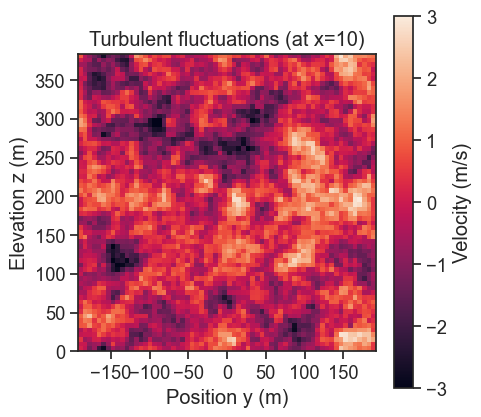

In [13]:
##Generate turbulence and rescale to fit the wanted turbulence intensity TI

# Generate the turbulent velocity fields
u_turb, v_turb, w_turb = VonKarmanTurbulenceField(Lx, Ly, Lz, Nx, Ny, Nz, L)

#Rescale of u_turb
u_turb = u_turb * (TI*U / u_turb.std())

U_turb = [u_turb, v_turb, w_turb]

_time = 10
plt.matshow(u_turb[:,:,_time], extent=[-Ly/2, Ly/2, 0, Lz], vmin=-3, vmax=3)
plt.colorbar(label="Velocity (m/s)")
plt.title(f"Turbulent fluctuations (at x={_time})")
plt.xlabel("Position y (m)")
plt.ylabel("Elevation z (m)")
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')

In [14]:
##Calculate the boundary layer wind

for i in range(Nz):
    u_turb[:,i,:] =  u_turb[:,i,:] + UShear(z = i/Nz*Lz)

TI = \frac{STD(U_turn)}{U}

C:\Users\louis\AppData\Local\Temp\ipykernel_25620\876925318.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Adjust for space on the right for the colorbar


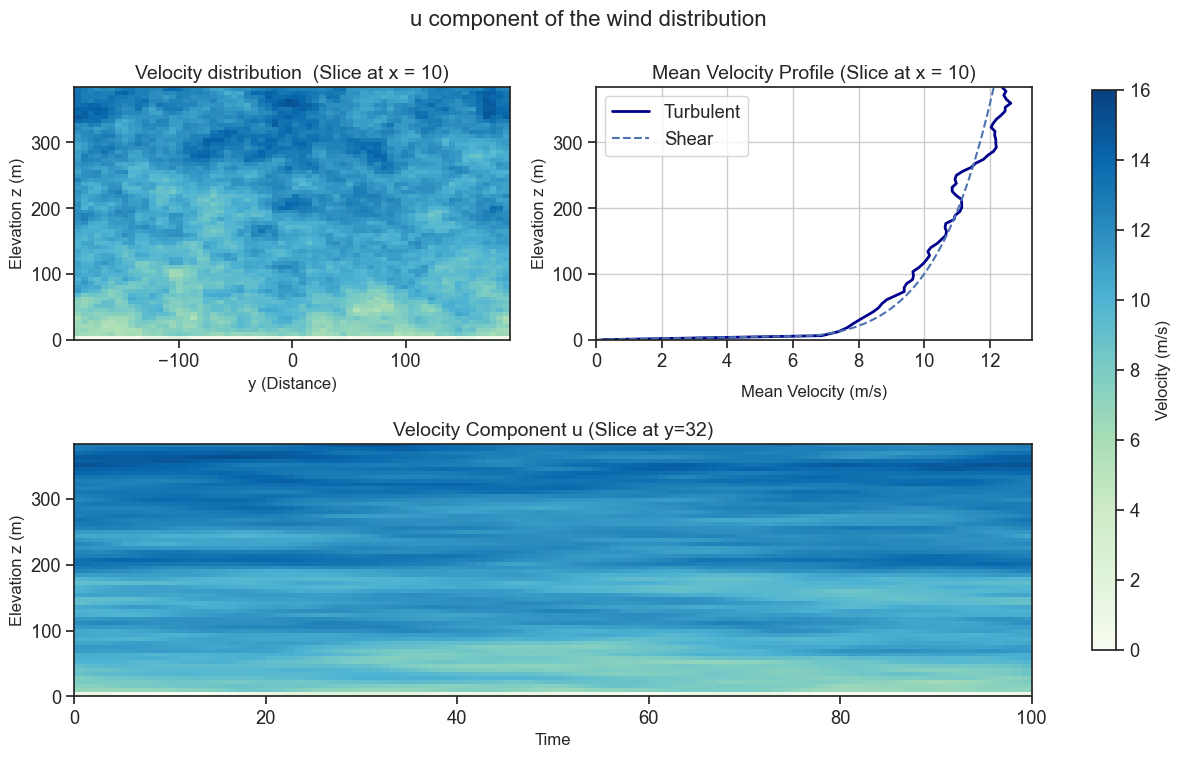

In [15]:
##Plot a sample of the wind velocity

time = 10

# Apply seaborn's theme and color palette
sns.set(style="ticks", palette="deep", font_scale=1.2)

# Creating the figure with 3 rows, the third one spanning both columns
fig = plt.figure(figsize=(12, 8))

# Main title for the entire figure
fig.suptitle("u component of the wind distribution", y=0.95, fontsize=16)

# Set the velocity range for the colorbar
vmin, vmax = 0, 16

# First plot: Velocity distribution (top left)
ax1 = plt.subplot2grid((2, 2), (0, 0))
im1 = ax1.imshow(u_turb[:, ::-1, time].T, extent=[-Ly/2, Ly/2, 0, Lz], aspect='auto', cmap="GnBu", vmin=vmin, vmax=vmax)
ax1.set_title(f'Velocity distribution  (Slice at x = {time})', fontsize=14)
ax1.set_xlabel('y (Distance)', fontsize=12)
ax1.set_ylabel('Elevation z (m)', fontsize=12)

# Second plot: Mean velocity profile (top right)
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(u_turb[:, :, time].mean(axis=0), np.linspace(0, Lz, Nz), color="darkblue", linewidth=2, label="Turbulent")
ax2.plot(UShear(np.linspace(0, Lz, Nz)), np.linspace(0, Lz, Nz), "--", label="Shear")
ax2.legend()
ax2.set_title(f'Mean Velocity Profile (Slice at x = {time})', fontsize=14)
ax2.set_xlabel('Mean Velocity (m/s)', labelpad=10, fontsize=12)
ax2.set_ylabel('Elevation z (m)', fontsize=12)
ax2.set_ylim(0, Lz)
ax2.set_xlim(0)
ax2.grid(True)

# Third plot: Full-width plot in the bottom row spanning both columns
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
y_pos = int(Ny / 2)
im2 = ax3.imshow(u_turb[y_pos, ::-1, :], aspect='auto', extent=[0, Lx, 0, Lz], cmap="GnBu", vmin=vmin, vmax=vmax)
ax3.set_title(f'Velocity Component u (Slice at y={y_pos})', fontsize=14)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('Elevation z (m)', fontsize=12)

# Single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position for the color bar [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Velocity (m/s)", fontsize=12)

# Adjust layout to ensure proper spacing
plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Adjust for space on the right for the colorbar


In [7]:
def integration_cubature57(f, R, weights_table):
    nodes = pd.read_csv(weights_table, delimiter=" ")
    result = 0
    for i in range(57):
        r = R * nodes["r"][i]  # scaling the radius
        phi = nodes["phi"][i]     # angle
        w = R**2 * nodes["w"][i] # scaled weight
        result += w * f(r, phi)

    return result

In [16]:
weights = pd.read_csv("./weight.dat", delimiter=" ")
weights

,w,y,z,r,phi
0,0.114983,0.000000,0.000000,0.000000,0.000000
1,0.042666,-0.886968,0.000000,0.886968,3.141593
2,0.042666,0.000000,-0.886968,0.886968,-1.570796
3,0.042666,0.000000,0.886968,0.886968,1.570796
4,0.042666,0.886968,0.000000,0.886968,0.000000
5,0.087938,-0.424634,0.000000,0.424634,3.141593
6,0.087938,0.000000,-0.424634,0.424634,-1.570796
7,0.087938,0.000000,0.424634,0.424634,1.570796
8,0.087938,0.424634,0.000000,0.424634,0.000000
9,0.076207,-0.694469,0.000000,0.694469,3.141593


In [9]:
def integrate_over_disk(f, R, nodes, weights):
    result = 0
    for i in range(len(nodes)):
        r = R * nodes[i][2]  # scaling the radius
        phi = nodes[i][3]     # angle
        w = R**2 * weights[i] # scaled weight
        result += w * f(r, phi)
    return result



def solve_dynamics_in_fourier(M, gamma, K, f_t, dt):
    # Fourier transform of forcing
    F_omega = np.fft.fft(f_t)
    
    # Frequency array
    omega = np.fft.fftfreq(len(f_t), dt) * 2 * np.pi
    
    # Solving in Fourier space
    epsilon = 1e-8  # Small damping factor to avoid division by zero
    X_omega = F_omega / (-omega**2 * M + 1j * omega * gamma + K + epsilon)

    
    # Inverse Fourier transform to get back to time domain
    x_t = np.fft.ifft(X_omega).real
    
    return x_t


In [10]:
unittest.main()

E
ERROR: C:\Users\louis\AppData\Local\Packages\PythonSoftwareFoundation (unittest.loader._FailedTest)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute 'C:\Users\louis\AppData\Local\Packages\PythonSoftwareFoundation'

----------------------------------------------------------------------
Ran 1 test in 0.002s

FAILED (errors=1)


SystemExit: True

C:\Users\louis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
